In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# load dataset
df = pd.read_csv('../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [3]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [4]:
y = df[label_columns]

In [5]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# build and train multi-label model
base_model = OneVsRestClassifier(XGBClassifier(eval_metric='logloss'))

# hyperparameter tuning
params = {
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.7, 1.0],
    'estimator__colsample_bytree': [0.7, 1.0],
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params,
    n_iter=50,
    cv=3,
    scoring='f1_micro',
    verbose=2,
    n_jobs=1
)

# build and train multi-label model
search.fit(X_train, y_train)

# pick the best model
model = search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.2, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.6s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.2, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.4s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.2, estimator__max_depth=3, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.3s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__max_depth=5, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.4s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__max_depth=5, estimator__n_estimators=100, estimator__subsample=1.0; total time=   1.0s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__ma

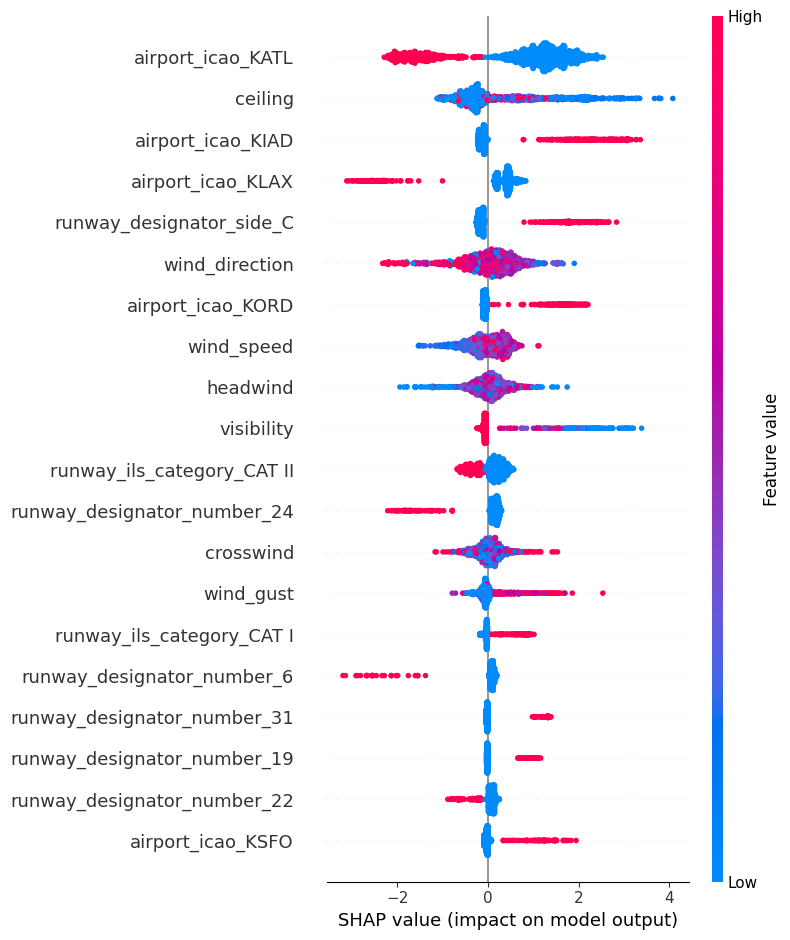

In [7]:
# ILS SHAP
explainer_ILS = shap.TreeExplainer(model.estimators_[0])
shap_ILS = explainer_ILS.shap_values(X_test)
shap.summary_plot(shap_ILS, X_test)

In [ ]:
print(search.best_params_)

In [ ]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()

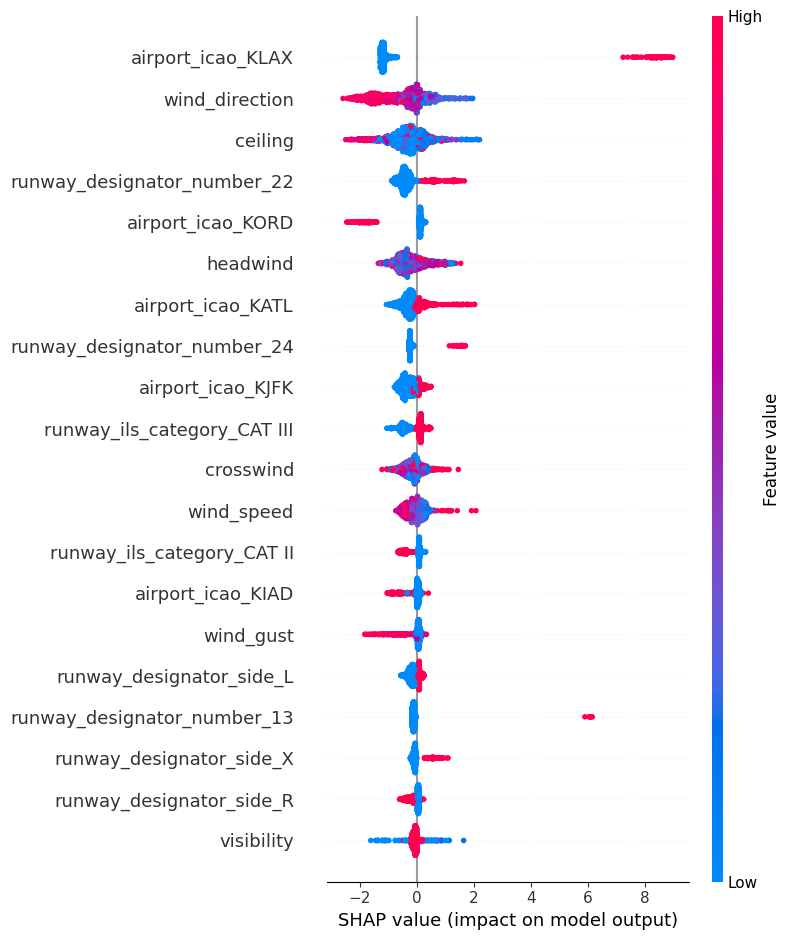

In [8]:
# RNAV SHAP
explainer_RNAV = shap.TreeExplainer(model.estimators_[1])
shap_RNAV = explainer_RNAV.shap_values(X_test)
shap.summary_plot(shap_RNAV, X_test)

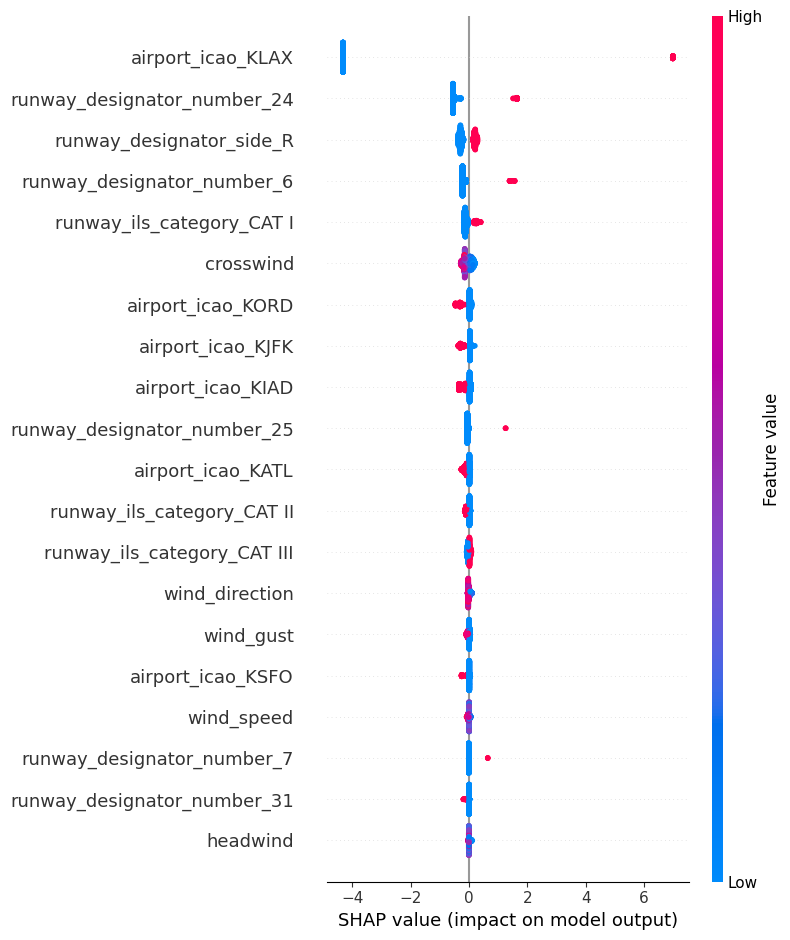

In [9]:
# RNP SHAP
explainer_RNP = shap.TreeExplainer(model.estimators_[2])
shap_RNP = explainer_RNP.shap_values(X_test)
shap.summary_plot(shap_RNP, X_test)

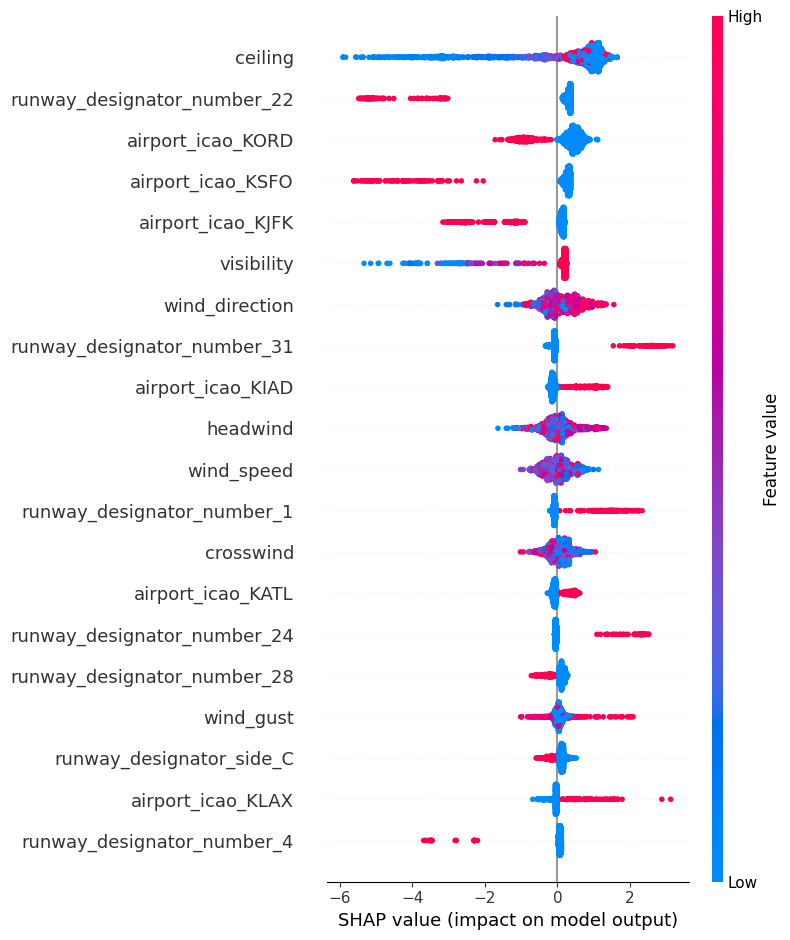

In [10]:
# VISUAL SHAP
explainer_VISUAL = shap.TreeExplainer(model.estimators_[3])
shap_VISUAL = explainer_VISUAL.shap_values(X_test)
shap.summary_plot(shap_VISUAL, X_test)

In [11]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 3 out of 1319
      visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
5589        10.0           6          0             130  6000.0       0.0   
3622        10.0           7          0             220  6000.0       3.5   
4742        10.0           7          0             220  6000.0       3.5   

      crosswind  ceiling  airport_icao_KATL  airport_icao_KIAD  ...  \
5589        6.0     -1.0              False              False  ...   
3622        6.1     -1.0               True              False  ...   
4742        6.1     -1.0               True              False  ...   

      runway_designator_number_28  runway_designator_number_30  \
5589                        False                        False   
3622                         True                        False   
4742                         True                        False   

      runway_designator_number_31  rvr_tendency_Deteriorating  \
5589                        